In [1]:
import os
import numpy as np
import pandas as pd
import json
import re
import gensim.downloader as api
import nltk
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer
from features import StylometryExtractor

glove_vectors_twitter = api.load("glove-twitter-200")
glove_vectors_wiki = api.load("glove-wiki-gigaword-300")
sbert_path = "weights/Siamese/fine-tuned-S-BERT"
sbert = SentenceTransformer(sbert_path)

C:\Users\aless\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Init directories

train_dir_easy = 'data/pan/easy/train'
train_dir_medium = 'data/pan/medium/train'
train_dir_hard = 'data/pan/hard/train'

train_set = [train_dir_easy, train_dir_medium, train_dir_hard]

eval_dir_easy = 'data/pan/easy/validation'
eval_dir_medium = 'data/pan/medium/validation'
eval_dir_hard = 'data/pan/hard/validation'

eval_set = [eval_dir_easy, eval_dir_medium, eval_dir_hard]

In [3]:
filename = "corpus.txt"

# Open the file in read mode
with open(filename, "r", encoding="utf-8") as file:
    # Read the contents of the file into a variable
    corpus = file.read()

print("Corpus read from", filename)

print(len(corpus))

my_extractor = StylometryExtractor(corpus)

Corpus read from corpus.txt
13127921


In [4]:
class Reddit_Parser():
    def __init__(self, train_path, eval_path, name, extractor):
        self.seed = 42
        self.name = name
        self.train_path = train_path
        self.eval_path = eval_path
        self.train_truth_table = pd.DataFrame(columns=['Paragraphs1', 'Paragraphs2', 'Truth_changes', 'file_number'])
        self.eval_truth_table = pd.DataFrame(columns=['Paragraphs1', 'Paragraphs2', 'Truth_changes', 'file_number'])
        self.train_single_sents = pd.DataFrame(columns=['Paragraphs', 'file_number', 'F_vector', 'W_embeddings', 'Sentence_embedding'])
        self.eval_single_sents = pd.DataFrame(columns=['Paragraphs', 'file_number', 'F_vector', 'W_embeddings', 'Sentence_embedding'])
        self.extractor = extractor
        self.extractor.preprocess_corpus()

    def openread(self, filename):
        try:
            with open(filename, 'r', encoding='utf-8') as file:
                # Perform operations on the file
                content = file.read()
                
        except FileNotFoundError:
            print(f"The file '{filename}' does not exist.")
        except IOError:
            print(f"An error occurred while trying to read the file '{filename}'.")

        return content
    
    ''' Supervised '''

    def parse_split(self, problem_title, truth_title):
        
        # Open everything
        problem_paragraphs = self.openread(problem_title).split('\n')
        pairs = [(problem_paragraphs[i], problem_paragraphs[i + 1]) for i in range(len(problem_paragraphs) - 1)]
        paragraphs1 = [t[0] for t in pairs]
        paragraphs2 = [t[1] for t in pairs]

        truth_paragraphs = self.openread(truth_title)
        parsed = json.loads(truth_paragraphs)

        if len(pairs) is not len(parsed['changes']):            # TODO: solve this problem without going by hand
            print(len(pairs))
            print(len(parsed['changes']))
            print("Paragraph/Truth mismatch in file", problem_title) 

        return problem_paragraphs, paragraphs1, paragraphs2, parsed['changes']

        # Returns a truth table with parsed paragraphs on column 0 and truth values on column 1
    
    def get_data(self):

        # Files in train
        train_truth_table = self.train_truth_table
        train_files = os.listdir(self.train_path)
        train_problems = [os.path.join(self.train_path, file) for file in train_files if file.startswith('p')]
        train_truths = [os.path.join(self.train_path, file) for file in train_files if file.startswith('t')]
        entries = []
        for problem_title, truth_title in zip(train_problems, train_truths):
            paragraphs_for_sentences, paragraphs1, paragraphs2, truths = self.parse_split(problem_title, truth_title)
            for i in range(len(paragraphs1)):
                train_truth_table.loc[len(train_truth_table)] = [paragraphs1[i], paragraphs2[i], truths[i], ''.join(re.findall(r'\d+', problem_title[-10:]))]
            entries.append(paragraphs_for_sentences)
        entries = [item for sublist in entries for item in sublist]
        entries = list(set(entries))
        for i in range(len(entries)):
            self.train_single_sents.loc[len(self.train_single_sents), 'Paragraphs'] = entries[i]

        # Files in eval
        eval_truth_table = self.eval_truth_table
        eval_files = os.listdir(self.eval_path)
        eval_problems = [os.path.join(self.eval_path, file) for file in eval_files if file.startswith('p')]
        eval_truths = [os.path.join(self.eval_path, file) for file in eval_files if file.startswith('t')]
        for problem_title, truth_title in zip(eval_problems, eval_truths):
            paragraphs_for_sentences, paragraphs1, paragraphs2, truths = self.parse_split(problem_title, truth_title)
            for i in range(len(paragraphs1)):
                eval_truth_table.loc[len(eval_truth_table)] = [paragraphs1[i], paragraphs2[i], truths[i], ''.join(re.findall(r'\d+', problem_title[-10:]))]
            entries.append(paragraphs_for_sentences)
        entries = [item for sublist in entries for item in sublist]
        entries = list(set(entries))
        for i in range(len(entries)):
            self.eval_single_sents.loc[len(self.eval_single_sents), 'Paragraphs'] = entries[i]
            

    def get_table_pairwise(self, table='train', csv=False):
        
        if not csv:
            if table == 'train':
                return self.train_truth_table
            elif table == 'eval':
                return self.eval_truth_table
            else:
                ValueError('Missing an argument. The argument should be -train- or -eval-')

        else:
            self.train_truth_table.to_csv(f"csv/train-table-{self.name}.csv", index=False)
            self.eval_truth_table.to_csv(f"csv/eval-table-{self.name}.csv", index=False)

    ''' Unsupervised '''
    
    # def get_sents(self, table='train', csv=False):

    #     entries = None
    #     if table == 'train':
    #         entries = self.train_truth_table['Paragraphs1']
    #         entries = [s for s in entries]
    #         entries = list(set(entries))
    #         for i in range(len(entries)):
    #             self.train_single_sents.loc[len(self.train_single_sents), 'Paragraphs'] = entries[i]
    #     elif table == 'eval':
    #         entries = self.eval_truth_table['Paragraphs1']
    #         entries = [s for s in entries]
    #         entries = list(set(entries))
            

    #     else: 
    #         ValueError('Missing an argument. The argument should be -train- or -eval-')

    #     if not csv:
    #         return entries, self.train_single_sents, self.eval_single_sents
    #     else:
    #         df = pd.DataFrame(entries)
    #         df.to_csv(f"csv/single-sents-{table}-{self.name}.csv", index=False, header=False)

    def sents_as_feature_vecs(self):

        if len(self.train_single_sents) == 0 and len(self.eval_single_sents) == 0:
            print("Call get_sents method before using this method")
            return
        paragraphs_train = self.train_single_sents['Paragraphs']
        paragraphs_eval = self.eval_single_sents['Paragraphs']
        train_fs = []
        eval_fs = []
        my_extractor = self.extractor

        for paragraph, _ in zip(paragraphs_train, range(len(paragraphs_train))):
            vec = my_extractor.stylometry_extractor(paragraph)      # Builds the train_feature_table
            train_fs.append(vec)
        self.train_single_sents['F_vector'] = train_fs

        for paragraph, _ in zip(paragraphs_eval, range(len(paragraphs_eval))):
            vec = my_extractor.stylometry_extractor(paragraph)      # Builds the eval_feature_table
            eval_fs.append(vec)
        self.eval_single_sents['F_vector'] = eval_fs

    def embedding_matrix_builder(self, sent, model):
        
        np.random.seed(self.seed)
        sent_lower = sent.lower()
        clean_sent = re.sub(r'[^a-zA-Z]', ' ', sent_lower)
        tokens = word_tokenize(clean_sent)
        W = []
        for token in tokens:
            if model == 'twitter':
                if token in glove_vectors_twitter:
                    token_embedding = glove_vectors_twitter[token]
                else:
                    token_embedding = np.random.uniform(-0.25, 0.25, 200)  # Random embedding
            else:
                if token in glove_vectors_twitter:
                    token_embedding = glove_vectors_twitter[token]
                else:
                    token_embedding = np.random.uniform(-0.25, 0.25, 200)  # Random embedding
            W.append(token_embedding)
        
        return W

    def sents_as_word_embedding_matrices(self, model='twitter'):
        
        if len(self.train_single_sents) == 0 and len(self.eval_single_sents) == 0:
            print("Call get_sents method before using this method")
            return

        paragraphs_train = self.train_single_sents['Paragraphs']
        paragraphs_eval = self.eval_single_sents['Paragraphs']
        
        train_embeddings = []
        eval_embeddings = []

        # Iterate over paragraphs_train and train_embeddings simultaneously
        for paragraph, _ in zip(paragraphs_train, range(len(paragraphs_train))):
            matrix = self.embedding_matrix_builder(paragraph, model)
            train_embeddings.append(matrix)
        self.train_single_sents['W_embeddings'] = train_embeddings

        # Iterate over paragraphs_eval and eval_embeddings simultaneously
        for paragraph, _ in zip(paragraphs_eval, range(len(paragraphs_eval))):
            matrix = self.embedding_matrix_builder(paragraph, model)
            eval_embeddings.append(matrix)
        self.eval_single_sents['W_embeddings'] = eval_embeddings
        
        return self.train_single_sents, self.eval_single_sents

    def sents_as_s_bert_embeddings(self):
        if len(self.train_single_sents) == 0 and len(self.eval_single_sents) == 0:
            print("Call get_sents method before using this method")
            return
        paragraphs_train = self.train_single_sents['Paragraphs']
        paragraphs_eval = self.eval_single_sents['Paragraphs']

        train_embeddings = []
        eval_embeddings = []

        for paragraph, _ in zip(paragraphs_train, range(len(paragraphs_train))):
            vec = sbert.encode(paragraph)      # Builds the train_feature_table
            train_embeddings.append(vec)
        self.train_single_sents['Sentence_embedding'] = train_embeddings
        for paragraph in paragraphs_eval:
            vec = sbert.encode(paragraph)      # Builds the eval_feature_table
            eval_embeddings.append(vec)
        self.eval_single_sents['Sentence_embedding'] = eval_embeddings
        return self.train_single_sents, self.eval_single_sents

    def get_table_single(self, table='train', csv=False):
        
        if not csv:
            if table == 'train':
                return self.train_single_sents
            elif table == 'eval':
                return self.eval_single_sents
            else:
                ValueError('Missing an argument. The argument should be -train- or -eval-')

        else:
            self.train_single_sents.to_csv(f"csv/train-singles-{self.name}.csv", index=False)
            self.eval_single_sents.to_csv(f"csv/eval-singles-{self.name}.csv", index=False)

In [5]:
myparser_easy = Reddit_Parser(train_dir_easy, eval_dir_easy, "easyparser", my_extractor)
myparser_medium = Reddit_Parser(train_dir_medium, eval_dir_medium, "mediumparser", my_extractor)
myparser_hard = Reddit_Parser(train_dir_hard, eval_dir_hard, "hardparser", my_extractor)

myparsers = [myparser_easy, myparser_medium, myparser_hard]

for parser in myparsers:
    parser.get_data()
    print("BUILT PARSER")

Saved corpus variable
lowered
tokenized
pos_tagged
general freq dist done
vocabulary initialized
adjectives done
conjunctions done
interrogatives done
nouns done
verbs done
3grams done
5grams done
oov done
collected freq_dists for adjectives
collected freq_dists for conjunctions
collected freq_dists for interrogatives
collected freq_dists for nouns
collected freq_dists for verbs
collected freq_dists for oovs
collected freq_dists for 3grams
collected freq_dists for 5grams
starting collecting most commons
Saved corpus variable
lowered
tokenized
pos_tagged
general freq dist done
vocabulary initialized
adjectives done
conjunctions done
interrogatives done
nouns done
verbs done
3grams done
5grams done
oov done
collected freq_dists for adjectives
collected freq_dists for conjunctions
collected freq_dists for interrogatives
collected freq_dists for nouns
collected freq_dists for verbs
collected freq_dists for oovs
collected freq_dists for 3grams
collected freq_dists for 5grams
starting collec

In [6]:
myparser_easy.get_table_single(csv=True)
myparser_medium.get_table_single(csv=True)
myparser_hard.get_table_single(csv=True)

In [27]:
pd.set_option('display.max_colwidth', None)

myparser_hard.train_truth_table.iloc[101]

Paragraphs1                                                                                                                                     Yes. I was making the point that this behavior is not going to go away because there is a system of those in service who continue to push this narrative for their own benefit. I have seen the behavior of some service members out in public and it clearly shows they are happy for the worship. They can be confrontational when they don't get it.
Paragraphs2      As a former service member, you are asking for a miracle. The hero idea is endemic within the service. It is akin to the police force. You're asking for individuals to give up their special treatment card and humbly accept that while the job is unique, it does not make someone special. It is still just a job and trust me when I say, not everyone who puts on the uniform is worth even the paycheck they receive. Sadly, those are usually the ones that demand the praise.
Truth_changes           

In [42]:
myparser_easy.get_table_pairwise('train')
myparser_easy.get_table_pairwise('eval')
myparser_medium.get_table_pairwise('train')
myparser_medium.get_table_pairwise('eval')
myparser_hard.get_table_pairwise('train')
myparser_hard.get_table_pairwise('eval')

,Paragraphs1,Paragraphs2,Truth_changes,file_number
0,"At least when you smear one second, you remain...",That's another way of saying that we all bette...,0,1
1,That's another way of saying that we all bette...,We already have very good synchronizing of clo...,0,1
2,We already have very good synchronizing of clo...,I think the earth's rotation and the year are ...,1,1
3,I think the earth's rotation and the year are ...,I would suggest that we replace months with de...,0,1
4,"I think you mean ""euphemisms"" - when you basic...","The whole ""false dichotomy"" things makes no se...",0,10
...,...,...,...,...
4130,Britian set up the West Africa Squadron to hun...,The British crown shipped more slaves to the A...,1,98
4131,It gives morons something to talk about. They ...,"If Biden did anything, it would be resign and ...",1,99
4132,"If Biden did anything, it would be resign and ...",Biden unilaterally overriding the voters (whic...,1,99
4133,Biden unilaterally overriding the voters (whic...,So this idea that would destroy the Democrats’...,0,99


In [43]:
all_train = pd.concat([myparser_easy.train_truth_table, myparser_medium.train_truth_table, myparser_hard.train_truth_table])
all_train.reset_index(drop=True, inplace=True)
all_train.to_csv(f"csv/train-table-all.csv", index=False)
all_eval = pd.concat([myparser_easy.eval_truth_table, myparser_medium.eval_truth_table, myparser_hard.eval_truth_table])
all_eval.reset_index(drop=True, inplace=True)
all_eval.to_csv(f"csv/eval-table-all.csv", index=False)

In [44]:
all_eval

,Paragraphs1,Paragraphs2,Truth_changes,file_number
0,My point still stands - with all their democra...,These are obviously not laws passed in the int...,1,1
1,These are obviously not laws passed in the int...,Not sure what else you drew from that. I could...,1,1
2,"In general, be courteous to others. Debate/dis...",I agree. Distinguishing between ideology and a...,1,10
3,I agree. Distinguishing between ideology and a...,Anarcho capitalists are nut jobs but their phi...,0,10
4,Anarcho capitalists are nut jobs but their phi...,"LG: Gay? I wish! If I were gay, there'd be no ...",1,10
...,...,...,...,...
11193,Britian set up the West Africa Squadron to hun...,The British crown shipped more slaves to the A...,1,98
11194,It gives morons something to talk about. They ...,"If Biden did anything, it would be resign and ...",1,99
11195,"If Biden did anything, it would be resign and ...",Biden unilaterally overriding the voters (whic...,1,99
11196,Biden unilaterally overriding the voters (whic...,So this idea that would destroy the Democrats’...,0,99


In [45]:
myparser_easy.sents_as_feature_vecs()
myparser_medium.sents_as_feature_vecs()
myparser_hard.sents_as_feature_vecs()

In [46]:
myparser_easy.sents_as_word_embedding_matrices()
myparser_medium.sents_as_word_embedding_matrices()
myparser_hard.sents_as_word_embedding_matrices()

(                                              Paragraphs file_number  \
 0      That's a power move. Only the Gigast of Chads ...         NaN   
 1      I watched in school like many of you. My scien...         NaN   
 2      Right? Kevin McCarthy is going to go insane tr...         NaN   
 3      But wait, there's more! TB is a perfect exampl...         NaN   
 4      I once got so exasperated at my high school ho...         NaN   
 ...                                                  ...         ...   
 23087  How about this.... the Democrats should say th...         NaN   
 23088  They need to stop actually letting the GOP use...         NaN   
 23089  We already have been allowing Erdogan to wage ...         NaN   
 23090  Justice has never been equal in any country ev...         NaN   
 23091  Nah its more of an anti gay bill than anything...         NaN   
 
                                                 F_vector  \
 0      [0.7904761904754376, 0.05714285714280272, 0.0,...   


In [47]:
myparser_hard.train_single_sents

,Paragraphs,file_number,F_vector,W_embeddings,Sentence_embedding
0,That's a power move. Only the Gigast of Chads ...,NaN,"[0.7904761904754376, 0.05714285714280272, 0.0,...","[[0.0097339, 0.41073, 0.080716, 0.34104, -0.53...",NaN
1,I watched in school like many of you. My scien...,NaN,"[0.7657894736840091, 0.03421052631578047, 0.0,...","[[0.056404, 0.49536, 0.18439, 0.054535, -0.517...",NaN
2,Right? Kevin McCarthy is going to go insane tr...,NaN,"[0.8079470198670147, 0.05298013245029604, 0.0,...","[[0.077965, -0.24248, -0.0027075, -0.22163, 0....",NaN
3,"But wait, there's more! TB is a perfect exampl...",NaN,"[0.792114695340218, 0.017921146953398595, 0.0,...","[[0.010517, 0.31645, -0.39336, 0.78182, -0.013...",NaN
4,I once got so exasperated at my high school ho...,NaN,"[0.770491803278478, 0.024590163934419512, 0.0,...","[[0.056404, 0.49536, 0.18439, 0.054535, -0.517...",NaN
...,...,...,...,...,...
23087,How about this.... the Democrats should say th...,NaN,"[0.8165137614677026, 0.022935779816508503, 0.0...","[[0.42447, 0.62584, 0.31371, 0.096825, -0.2507...",NaN
23088,They need to stop actually letting the GOP use...,NaN,"[0.8067484662574212, 0.030674846625757462, 0.0...","[[-0.17592, 0.34639, -0.085563, 0.74169, -0.01...",NaN
23089,We already have been allowing Erdogan to wage ...,NaN,"[0.7866242038214055, 0.03821656050954197, 0.00...","[[0.1585, 0.27084, 0.11364, 0.23606, -0.011571...",NaN
23090,Justice has never been equal in any country ev...,NaN,"[0.7938144329892816, 0.025773195876275377, 0.0...","[[-0.010654, 0.42421, -0.51016, 0.61992, 0.053...",NaN


In [48]:
myparser_easy.sents_as_s_bert_embeddings()

# Around 4 min

(                                              Paragraphs file_number  \
 0      You go down the list until you get to the firs...         NaN   
 1      What a load of bullshit. More like Kadyrov isn...         NaN   
 2      I forgot. King car is freedom. A society where...         NaN   
 3      Government corruption into the highest echelon...         NaN   
 4      the Canada US trade relationship has been the ...         NaN   
 ...                                                  ...         ...   
 13011  >Wishma stated that she wanted to return to Sr...         NaN   
 13012  Haiti got screwed hard by France after the war...         NaN   
 13013  Unfortunately, many of the things that the US ...         NaN   
 13014  Look into the recent history of China saying a...         NaN   
 13015  Still, taking that into account: 50+ has twice...         NaN   
 
                                                 F_vector  \
 0      [0.8112676056335744, 0.011267605633799643, 0.0...   


In [49]:
myparser_medium.sents_as_s_bert_embeddings()


(                                              Paragraphs file_number  \
 0      Yet detractors keep saying that the intermitte...         NaN   
 1      He also advised Bolsonaro on how to 'handle' C...         NaN   
 2      > “Its inadequacy as a legal claim was evident...         NaN   
 3      If you mentioned that the US didn’t claim part...         NaN   
 4      Edit Thing 3: Here is my prediction of what pr...         NaN   
 ...                                                  ...         ...   
 19801  Hopefully the Strykers/LAV's (and similar) wil...         NaN   
 19802  It won't be a permanent state if affairs, and ...         NaN   
 19803  Except your idea there is extremely unlikely d...         NaN   
 19804  The US financed the rebuilding of vastly more ...         NaN   
 19805  They have been buying missiles and artillery f...         NaN   
 
                                                 F_vector  \
 0      [0.8407079646010259, 0.008849557522116061, 0.0...   


In [50]:
myparser_hard.sents_as_s_bert_embeddings()

(                                              Paragraphs file_number  \
 0      That's a power move. Only the Gigast of Chads ...         NaN   
 1      I watched in school like many of you. My scien...         NaN   
 2      Right? Kevin McCarthy is going to go insane tr...         NaN   
 3      But wait, there's more! TB is a perfect exampl...         NaN   
 4      I once got so exasperated at my high school ho...         NaN   
 ...                                                  ...         ...   
 23087  How about this.... the Democrats should say th...         NaN   
 23088  They need to stop actually letting the GOP use...         NaN   
 23089  We already have been allowing Erdogan to wage ...         NaN   
 23090  Justice has never been equal in any country ev...         NaN   
 23091  Nah its more of an anti gay bill than anything...         NaN   
 
                                                 F_vector  \
 0      [0.7904761904754376, 0.05714285714280272, 0.0,...   


In [51]:
myparser_medium.train_single_sents.iloc[5891]['F_vector']

array([8.02547771e-01, 1.59235669e-02, 6.36942675e-03, 1.71974522e-01,
       2.89808917e-01, 1.97802198e-01, 3.73626374e-01, 1.53846154e-01,
       2.41758242e-01, 3.29670330e-02, 5.73248408e-02, 3.13492063e-01,
       1.90476190e-01, 1.07142857e-01, 2.77777778e-02, 2.65822785e-01,
       2.40506329e-01, 1.51898734e-01, 1.77215190e-01, 1.64556962e-01,
       2.91666667e-01, 2.29166667e-01, 1.45833333e-01, 1.66666667e-01,
       1.66666667e-01, 2.59259259e-01, 1.11111111e-01, 2.59259259e-01,
       1.11111111e-01, 2.59259259e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.82108626e-01, 2.20447284e-01, 2.07667732e-01, 2.23642173e-02,
       5.26315789e-02, 3.50877193e-02, 1.75438596e-01, 7.24637681e-02,
       1.01449275e-01, 5.79710145e-02, 1.44927536e-02, 4.34782609e-02,
       4.34782609e-02, 5.79710145e-02, 1.44927536e-02, 1.07692308e-01,
       4.61538462e-02, 1.53846154e-02, 1.42857143e-01, 1.27795527e-02,
      

In [52]:
# Let's start from sentences

import pickle

table1_train = myparser_easy.train_single_sents
with open('table_easy_train.pkl', 'wb') as f:
    pickle.dump(table1_train, f)
table2_train = myparser_medium.train_single_sents
with open('table_medium_train.pkl', 'wb') as f:
    pickle.dump(table2_train, f)
table3_train = myparser_hard.train_single_sents
with open('table_hard_train.pkl', 'wb') as f:
    pickle.dump(table3_train, f)

table_all_train = pd.concat([table1_train, table2_train, table3_train])
table_all_train.reset_index(drop=True, inplace=True)

table_all_train
with open('table_all_train.pkl', 'wb') as f:
    pickle.dump(table_all_train, f)

In [53]:
import pickle
import pandas as pd
with open('table_all_train.pkl', 'rb') as f:
    loaded_df = pickle.load(f)

loaded_df

,Paragraphs,file_number,F_vector,W_embeddings,Sentence_embedding
0,You go down the list until you get to the firs...,NaN,"[0.8112676056335744, 0.011267605633799643, 0.0...","[[0.1964, 0.67153, 0.0062976, 0.25359, -0.4209...","[-0.0108818365, -0.055236436, 0.0716428, -0.08..."
1,What a load of bullshit. More like Kadyrov isn...,NaN,"[0.7820512820509479, 0.03418803418801958, 0.0,...","[[0.55608, 0.61558, 0.27908, 0.3404, -0.46537,...","[-0.022359412, -0.056606997, 0.0458473, 0.0372..."
2,I forgot. King car is freedom. A society where...,NaN,"[0.7569060773476481, 0.022099447513799948, 0.0...","[[0.056404, 0.49536, 0.18439, 0.054535, -0.517...","[0.026828578, 0.05234322, -0.014839226, 0.0422..."
3,Government corruption into the highest echelon...,NaN,"[0.8041666666664992, 0.022916666666661895, 0.0...","[[0.25365, 0.14061, -0.40399, 0.53913, -0.3481...","[0.032579094, -0.0075427317, 0.0006501316, -0...."
4,the Canada US trade relationship has been the ...,NaN,"[0.7972972972971993, 0.04054054054053556, 0.00...","[[0.4935, 0.35698, 0.66068, -0.032975, 0.24989...","[-0.009932141, -0.06898273, 0.04389227, 0.0298..."
...,...,...,...,...,...
55909,How about this.... the Democrats should say th...,NaN,"[0.8165137614677026, 0.022935779816508503, 0.0...","[[0.42447, 0.62584, 0.31371, 0.096825, -0.2507...","[-0.12770526, 0.01907035, 0.034745224, -0.0512..."
55910,They need to stop actually letting the GOP use...,NaN,"[0.8067484662574212, 0.030674846625757462, 0.0...","[[-0.17592, 0.34639, -0.085563, 0.74169, -0.01...","[-0.0016268938, -0.011135953, 0.030946355, -0...."
55911,We already have been allowing Erdogan to wage ...,NaN,"[0.7866242038214055, 0.03821656050954197, 0.00...","[[0.1585, 0.27084, 0.11364, 0.23606, -0.011571...","[0.030857958, 0.01808282, 0.03273155, -0.02004..."
55912,Justice has never been equal in any country ev...,NaN,"[0.7938144329892816, 0.025773195876275377, 0.0...","[[-0.010654, 0.42421, -0.51016, 0.61992, 0.053...","[0.043086704, 0.008515414, -0.01145746, -0.079..."


In [54]:
table1_eval = myparser_easy.eval_single_sents
with open('table_easy_eval.pkl', 'wb') as f:
    pickle.dump(table1_train, f)
table2_eval = myparser_medium.eval_single_sents
with open('table_medium_eval.pkl', 'wb') as f:
    pickle.dump(table2_eval, f)
table3_eval = myparser_hard.eval_single_sents
with open('table_hard_eval.pkl', 'wb') as f:
    pickle.dump(table3_eval, f)

table_all_eval = pd.concat([table1_eval, table2_eval, table3_eval])
table_all_eval.reset_index(drop=True, inplace=True)
with open('table_all_eval.pkl', 'wb') as f:
    pickle.dump(table_all_eval, f)

In [55]:
# Here we run component analysis - EASY

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler_for_features = StandardScaler()
scaler_for_word_embeddings = StandardScaler()
scaler_for_sentence_embeddings = StandardScaler()

# F_vectors

F_vectors_easy = np.array(table1_train['F_vector'].tolist())
print(F_vectors_easy.shape)

scaler_for_features.fit(F_vectors_easy)
scaled_F_vectors_easy = scaler_for_features.transform(F_vectors_easy)

pca = PCA(n_components=2)
principal_components_f_easy = pca.fit_transform(scaled_F_vectors_easy)
print(principal_components_f_easy)

# Sent_embeddings

Sent_easy = np.array(table1_train['Sentence_embedding'].tolist())
print(Sent_easy.shape)

scaler_for_sentence_embeddings.fit(Sent_easy)
scaled_Sent_easy = scaler_for_sentence_embeddings.transform(Sent_easy)

pca = PCA(n_components=2)
principal_components_sent_easy = pca.fit_transform(scaled_Sent_easy)

(13016, 383)
[[-6.37034286e-03 -2.52662618e+00]
 [-2.78908067e+00 -3.32105048e+00]
 [-3.48168960e+00 -1.04436668e+00]
 ...
 [ 7.65935473e-01  2.73332962e+00]
 [ 8.27856867e+00 -1.03882562e+00]
 [-5.23707570e+00 -2.11054144e+00]]
(13016, 384)


In [116]:
principal_components_sent_easy

array([[-2.8808858 ,  2.6742005 ],
       [ 6.189099  ,  6.1189656 ],
       [-2.852454  , -4.5385804 ],
       ...,
       [-1.9488093 ,  0.24939156],
       [ 4.51841   , -2.8027885 ],
       [-3.8667586 , -1.5401865 ]], dtype=float32)

In [110]:
# MEDIUM

scaler_for_features = StandardScaler()
scaler_for_word_embeddings = StandardScaler()
scaler_for_sentence_embeddings = StandardScaler()

# F_vectors

F_vectors_medium = np.array(table2_train['F_vector'].tolist())
F_vectors_hard = np.array(table3_train['F_vector'].tolist())
print(F_vectors_medium.shape)

scaler_for_features.fit(F_vectors_medium)
scaled_F_vectors_medium = scaler_for_features.transform(F_vectors_medium)

pca = PCA(n_components=2)
principal_components_f_medium = pca.fit_transform(scaled_F_vectors_medium)
print(principal_components_f_medium)

# Sent_embeddings

Sent_medium = np.array(table2_train['Sentence_embedding'].tolist())
Sent_hard = np.array(table3_train['Sentence_embedding'].tolist())

scaler_for_sentence_embeddings.fit(Sent_medium)
scaled_Sent_medium = scaler_for_sentence_embeddings.transform(Sent_medium)

pca = PCA(n_components=2)
principal_components_sent_medium = pca.fit_transform(scaled_Sent_medium)

(19806, 383)
[[-4.68616416 -4.58545919]
 [-2.4166082  -2.35874331]
 [ 0.58268156 -1.07414052]
 ...
 [12.75820366  1.81794471]
 [-2.23489577 -8.47701226]
 [-3.78068559 -4.20605718]]


In [115]:
principal_components_sent_medium

array([[-1.948888  , -4.857545  ],
       [-0.3195515 ,  0.60548806],
       [-1.5062152 ,  2.5357943 ],
       ...,
       [ 0.88491416, -0.7742069 ],
       [ 3.512309  , -1.141043  ],
       [ 6.9021115 , -1.1822698 ]], dtype=float32)

In [112]:
# HARD

scaler_for_features = StandardScaler()
scaler_for_word_embeddings = StandardScaler()
scaler_for_sentence_embeddings = StandardScaler()

# F_vectors

F_vectors_hard = np.array(table3_train['F_vector'].tolist())
print(F_vectors_hard.shape)

scaler_for_features.fit(F_vectors_hard)
scaled_F_vectors_hard = scaler_for_features.transform(F_vectors_hard)

pca = PCA(n_components=2)
principal_components_f_hard = pca.fit_transform(scaled_F_vectors_hard)
print(principal_components_f_hard)

# Sent_embeddings
Sent_hard = np.array(table3_train['Sentence_embedding'].tolist())

scaler_for_sentence_embeddings.fit(Sent_hard)
scaled_Sent_hard = scaler_for_sentence_embeddings.transform(Sent_hard)

pca = PCA(n_components=2)
principal_components_sent_hard = pca.fit_transform(scaled_Sent_hard)

(23092, 383)
[[-4.95264322 -5.07612824]
 [ 4.87958938 -6.64886166]
 [-3.58571431  1.69469005]
 ...
 [ 1.83685367 -3.54392504]
 [-1.9697603  -1.54639474]
 [-4.21659126 -0.31966398]]


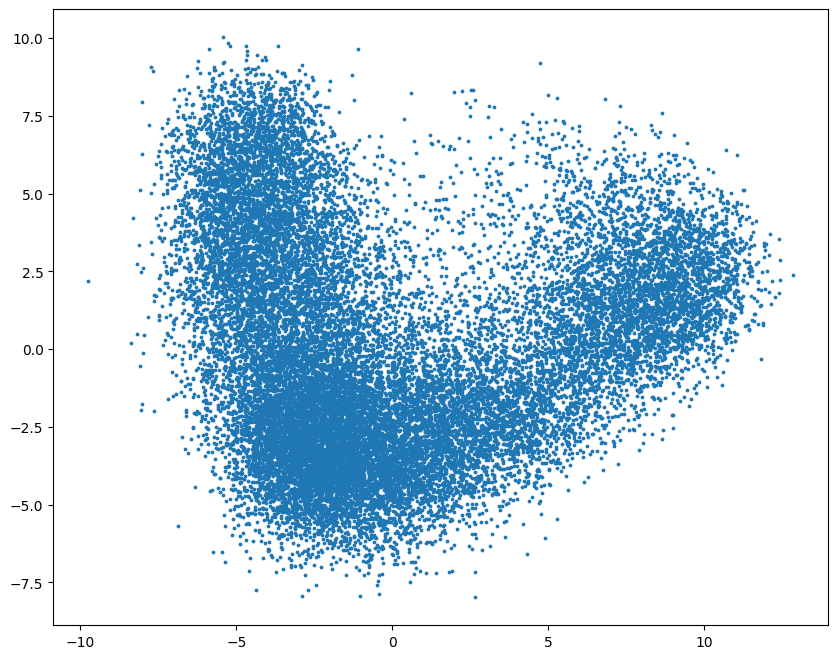

In [149]:
import matplotlib.pyplot as plt

# All tables

x0 = principal_components_sent_hard[:, 0]
y0 = principal_components_sent_hard[:, 1]

plt.figure(figsize=(10, 8))
plt.scatter(x0, y0, s=3)
plt.show()


# axs[1].scatter(x1, y1)
# axs[1].set_title('Word embeddings')
# axs[1].set_xlabel('X')
# axs[1].set_ylabel('Y')

# axs[2].scatter(x2, y2)
# axs[2].set_title('Sentence embeddings')
# axs[2].set_xlabel('X')
# axs[2].set_ylabel('Y')


table3_train['Sent_PCA'] = [x for x in principal_components_sent_hard]

In [150]:
table3_train

,Paragraphs,file_number,F_vector,W_embeddings,Sentence_embedding,Sent_PCA
0,That's a power move. Only the Gigast of Chads ...,NaN,"[0.7904761904754376, 0.05714285714280272, 0.0,...","[[0.0097339, 0.41073, 0.080716, 0.34104, -0.53...","[-0.041815493, 0.046778947, -0.0057730754, -0....","[-2.2459753, 0.2746618]"
1,I watched in school like many of you. My scien...,NaN,"[0.7657894736840091, 0.03421052631578047, 0.0,...","[[0.056404, 0.49536, 0.18439, 0.054535, -0.517...","[-0.029988578, 0.021727158, 0.050818864, -0.01...","[-5.575555, 0.23974444]"
2,Right? Kevin McCarthy is going to go insane tr...,NaN,"[0.8079470198670147, 0.05298013245029604, 0.0,...","[[0.077965, -0.24248, -0.0027075, -0.22163, 0....","[0.081518516, 0.013118521, -0.020434242, -0.03...","[-1.5132809, 3.5815916]"
3,"But wait, there's more! TB is a perfect exampl...",NaN,"[0.792114695340218, 0.017921146953398595, 0.0,...","[[0.010517, 0.31645, -0.39336, 0.78182, -0.013...","[0.11972425, -0.041902646, -0.019302327, -0.05...","[2.890255, -2.451757]"
4,I once got so exasperated at my high school ho...,NaN,"[0.770491803278478, 0.024590163934419512, 0.0,...","[[0.056404, 0.49536, 0.18439, 0.054535, -0.517...","[-0.06112073, 0.10971879, 0.0072471113, 0.0125...","[-4.2428613, -3.3918164]"
...,...,...,...,...,...,...
23087,How about this.... the Democrats should say th...,NaN,"[0.8165137614677026, 0.022935779816508503, 0.0...","[[0.42447, 0.62584, 0.31371, 0.096825, -0.2507...","[-0.12770526, 0.01907035, 0.034745224, -0.0512...","[-4.743045, 5.158454]"
23088,They need to stop actually letting the GOP use...,NaN,"[0.8067484662574212, 0.030674846625757462, 0.0...","[[-0.17592, 0.34639, -0.085563, 0.74169, -0.01...","[-0.0016268938, -0.011135953, 0.030946355, -0....","[-5.5773215, 3.3281822]"
23089,We already have been allowing Erdogan to wage ...,NaN,"[0.7866242038214055, 0.03821656050954197, 0.00...","[[0.1585, 0.27084, 0.11364, 0.23606, -0.011571...","[0.030857958, 0.01808282, 0.03273155, -0.02004...","[5.3999877, 0.9916496]"
23090,Justice has never been equal in any country ev...,NaN,"[0.7938144329892816, 0.025773195876275377, 0.0...","[[-0.010654, 0.42421, -0.51016, 0.61992, 0.053...","[0.043086704, 0.008515414, -0.01145746, -0.079...","[-3.2693126, 1.1268225]"


In [151]:
table3_train['F_PCA'] = [x for x in principal_components_f_hard]

myparser_hard.train_truth_table

,Paragraphs1,Paragraphs2,Truth_changes,file_number
0,I'm not gonna watch the video. I gotta keep my...,Maybe police agencies should be not federalize...,1,1
1,Maybe police agencies should be not federalize...,Actual combat soldiers have much more discipli...,0,1
2,Actual combat soldiers have much more discipli...,"Police departments attract brutes, do nothing ...",1,1
3,"That's false, there are several factions invol...",Houthi Rebels representing Houthis that have b...,1,10
4,Houthi Rebels representing Houthis that have b...,"The Saudi bombing campaign has been atrocious,...",1,10
...,...,...,...,...
19010,"This is genocide, the destruction of a people ...","Either way, we agree that what Russia is doing...",1,999
19011,"Either way, we agree that what Russia is doing...","Apologies for being pedantic here, I agree wit...",0,999
19012,"Apologies for being pedantic here, I agree wit...","Exactly! This is no place for Euphemisms, Russ...",0,999
19013,"Exactly! This is no place for Euphemisms, Russ...",The boy children will be trained for war and t...,1,999


In [152]:
table3_train[20:40]

,Paragraphs,file_number,F_vector,W_embeddings,Sentence_embedding,Sent_PCA,F_PCA
20,Given that recent strains have been exceptiona...,NaN,"[0.8150134048255188, 0.008042895442357093, 0.0...","[[0.23764, 0.16421, -0.14991, 0.31657, -0.1598...","[0.0096185785, 0.020627705, 0.052153643, 0.006...","[-2.1897361, -5.014847]","[3.628110200068311, 3.47447506335856]"
21,"Also, perhaps more importantly, Manchin is 100...",NaN,"[0.7727272727266874, 0.03787878787875919, 0.03...","[[0.19304, 0.11044, -0.30851, -0.12108, -0.491...","[0.11378418, -0.041011292, -0.010180956, -0.03...","[-3.5867085, 4.593076]","[-4.68571472848303, 1.1770760452964264]"
22,dont get me wrong i think we are long overdue ...,NaN,"[0.8098159509197487, 0.0, 0.0, 0.1779141104293...","[[-0.33784, 0.54451, -0.1921, 0.43394, -0.4804...","[0.025592037, -0.06712537, 0.021761293, -0.118...","[-4.629309, 1.9836651]","[-2.473019241544776, 1.1178599810472811]"
23,"I have had fantasies of a ""Thanos snap"" to mak...",NaN,"[0.7901234567896358, 0.01234567901233806, 0.0,...","[[0.056404, 0.49536, 0.18439, 0.054535, -0.517...","[0.010895891, -0.0089115985, 0.08840856, -0.05...","[-4.762308, 3.9204512]","[-2.871793392152204, -2.6912814809148946]"
24,The EU is unconditionally by Ukraine's side. W...,NaN,"[0.8013937282227174, 0.05226480836235113, 0.0,...","[[0.4935, 0.35698, 0.66068, -0.032975, 0.24989...","[-0.039384596, 0.052042533, 0.06859862, -0.011...","[8.421703, 0.023338052]","[0.9139994972524408, -1.3379451545300731]"
25,"What do you mean ""most of the time""? Almost ev...",NaN,"[0.7735849056596475, 0.02830188679242613, 0.0,...","[[0.55608, 0.61558, 0.27908, 0.3404, -0.46537,...","[0.05849962, -0.0618182, 0.015068628, 0.003299...","[-3.9640088, -3.746844]","[-5.117058729434412, -3.7977559119109636]"
26,My favorite part was when McCarthy said he was...,NaN,"[0.8087248322144938, 0.013422818791941805, 0.0...","[[0.047356, -0.10216, -0.15738, -0.04521, 0.26...","[-0.015923817, 0.09170947, 0.0002651037, 0.022...","[-4.07531, 5.0059805]","[1.5138963454575372, 0.33085071611795824]"
27,But the same scientist who published this arti...,NaN,"[0.8020304568523848, 0.010152284263954238, 0.0...","[[0.010517, 0.31645, -0.39336, 0.78182, -0.013...","[-0.037739344, 0.078958966, 0.04668317, 0.1096...","[-1.4902828, -3.8712566]","[-2.106403574401656, 0.5842338619512665]"
28,I think we need to stop grouping being disrupt...,NaN,"[0.8296943231437426, 0.008733624454144658, 0.0...","[[0.056404, 0.49536, 0.18439, 0.054535, -0.517...","[0.076841734, -0.019819118, 0.023385447, -0.04...","[-2.4793103, -3.66718]","[-1.1138164824527002, 3.363755764772314]"
29,I don’t know how it worked tbh. I heard about ...,NaN,"[0.7621951219507548, 0.03658536585363623, 0.0,...","[[0.056404, 0.49536, 0.18439, 0.054535, -0.517...","[-0.03750954, 0.03642732, -0.012846114, 0.0208...","[0.19515076, -3.2765372]","[-2.66483185046075, -7.02188675464959]"


In [185]:
p1 = myparser_hard.train_truth_table['Paragraphs1']
p2 = myparser_hard.train_truth_table['Paragraphs2']

for idx, p in enumerate(p1):
    location = table3_train[table3_train['Paragraphs'] == p]
    myparser_hard.train_truth_table.at[idx, 'F_vec1'] = location['F_vector'].values[0]
    myparser_hard.train_truth_table.at[idx, 'Sent_PCA1'] = location['Sent_PCA'].values[0]

for idx, p in enumerate(p2):
    location = table3_train[table3_train['Paragraphs'] == p]
    myparser_hard.train_truth_table.at[idx, 'F_vec2'] = location['F_vector'].values[0]
    myparser_hard.train_truth_table.at[idx, 'Sent_PCA2'] = location['Sent_PCA'].values[0]


In [186]:
myparser_hard.train_truth_table

,Paragraphs1,Paragraphs2,Truth_changes,file_number,F_PCA1,Sent_PCA1,F_PCA2,Sent_PCA2,F_sim,S_sim,F_vec1,F_vec2
0,I'm not gonna watch the video. I gotta keep my...,Maybe police agencies should be not federalize...,1,1,"[2.4440812798723597, -5.111087989385538]","[-0.4657336, -0.99528146]","[-2.5636943446237246, 1.6043367314682]","[-2.4604516, -3.5881193]",8.377037,3.271347,"[0.7915309446251494, 0.019543973941361713, 0.0...","[0.7828571428566956, 0.022857142857129798, 0.0..."
1,Maybe police agencies should be not federalize...,Actual combat soldiers have much more discipli...,0,1,"[-2.5636943446237246, 1.6043367314682]","[-2.4604516, -3.5881193]","[1.6819302825464082, -0.21885770483900646]","[-0.40308434, -3.1045234]",4.620537,2.113439,"[0.7828571428566956, 0.022857142857129798, 0.0...","[0.8006644518269765, 0.03322259136211521, 0.0,..."
2,Actual combat soldiers have much more discipli...,"Police departments attract brutes, do nothing ...",1,1,"[1.6819302825464082, -0.21885770483900646]","[-0.40308434, -3.1045234]","[0.18817898757686619, 0.22800986377690896]","[-0.8852291, -0.9042495]",1.559161,2.252481,"[0.8006644518269765, 0.03322259136211521, 0.0,...","[0.8124999999996827, 0.031249999999987794, 0.0..."
3,"That's false, there are several factions invol...",Houthi Rebels representing Houthis that have b...,1,10,"[5.213861096765197, 3.864292687077905]","[1.3593627, -2.9110518]","[-1.466276403702117, 6.76107024425501]","[1.4042888, -0.21381599]",7.281178,2.697610,"[0.8141809290951555, 0.06845965770169475, 0.0,...","[0.8523809523805466, 0.028571428571414967, 0.0..."
4,Houthi Rebels representing Houthis that have b...,"The Saudi bombing campaign has been atrocious,...",1,10,"[-1.466276403702117, 6.76107024425501]","[1.4042888, -0.21381599]","[-3.3673676029230935, 4.4170379940677105]","[1.0668019, -0.51956576]",3.018052,0.455390,"[0.8523809523805466, 0.028571428571414967, 0.0...","[0.8397435897430515, 0.03846153846151381, 0.0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...
19010,"This is genocide, the destruction of a people ...","Either way, we agree that what Russia is doing...",1,999,"[-2.3555378650302132, 2.7358910635311497]","[8.671207, 2.5433593]","[-3.194426727036556, -0.0043124918180812745]","[6.5494733, 1.3548441]",2.865737,2.431938,"[0.8163265306118285, 0.020408163265295712, 0.0...","[0.8101265822779683, 0.012658227848093255, 0.0..."
19011,"Either way, we agree that what Russia is doing...","Apologies for being pedantic here, I agree wit...",0,999,"[-3.194426727036556, -0.0043124918180812745]","[6.5494733, 1.3548441]","[4.639792992000271, 2.9367983795711994]","[1.2477859, -5.331929]",8.368102,8.533512,"[0.8101265822779683, 0.012658227848093255, 0.0...","[0.8110831234254884, 0.017632241813597575, 0.0..."
19012,"Apologies for being pedantic here, I agree wit...","Exactly! This is no place for Euphemisms, Russ...",0,999,"[4.639792992000271, 2.9367983795711994]","[1.2477859, -5.331929]","[-0.10264543784504393, 1.1268911866740627]","[7.6024246, -0.2881788]",5.076070,8.113005,"[0.8110831234254884, 0.017632241813597575, 0.0...","[0.815686274509484, 0.03529411764704499, 0.0, ..."
19013,"Exactly! This is no place for Euphemisms, Russ...",The boy children will be trained for war and t...,1,999,"[-0.10264543784504393, 1.1268911866740627]","[7.6024246, -0.2881788]","[-3.9004928298429, -1.971572373297482]","[1.6673486, -2.6338513]",4.901441,6.381795,"[0.815686274509484, 0.03529411764704499, 0.0, ...","[0.8124999999993653, 0.007812499999993897, 0.0..."


In [188]:
from sklearn.metrics.pairwise import cosine_similarity
import math

F_sim_values = []
S_sim_values = []

for index, row in myparser_hard.train_truth_table.iterrows():
    value1 = np.array(row['F_vec1'])
    value2 = np.array(row['F_vec2'])
    result1 = cosine_similarity([value1], [value2])[0][0]
    value3 = row['Sent_PCA1']
    value4 = row['Sent_PCA2']
    result2 = math.sqrt((value3[1] - value4[1])**2 + (value3[0] - value4[0])**2)
    F_sim_values.append(result1)
    S_sim_values.append(result2)

myparser_hard.train_truth_table['F_sim'] = F_sim_values
myparser_hard.train_truth_table['S_sim'] = S_sim_values

In [189]:
myparser_medium.train_truth_table.head()

,Paragraphs1,Paragraphs2,Truth_changes,file_number,F_PCA1,Sent_PCA1,F_PCA2,Sent_PCA2,F_sim,S_sim
0,How is this comment considered okay? It wouldn...,Also could be important as a lot of people thi...,1,1,"[31.39086880935744, -1.3053105975822101]","[6.8284917, 3.3427489]","[-2.771539265220399, -1.9346997707951368]","[6.1625757, 3.1089618]",34.168205,0.705762
1,"In general, be courteous to others. Debate/dis...",For those who have questions regarding any med...,0,10,"[-0.2326549448096662, -3.288870083049564]","[-3.280429, -1.5541853]","[-2.897812621273479, -4.485126911071934]","[-1.006791, -1.9293879]",2.921317,2.304388
2,For those who have questions regarding any med...,I personally think the abuse of the PPP money ...,1,10,"[-2.897812621273479, -4.485126911071934]","[-1.006791, -1.9293879]","[-0.38655588338024705, 1.151428673118031]","[-1.8601887, -2.2295375]",6.170670,0.904642
3,I personally think the abuse of the PPP money ...,"I am a bot, and this action was performed auto...",1,10,"[-0.38655588338024705, 1.151428673118031]","[-1.8601887, -2.2295375]","[-4.694968996186388, -2.2997334127889326]","[-1.1404161, -2.0022395]",5.520230,0.754809
4,"I am a bot, and this action was performed auto...",Thank goodness Rep. James Comer is all over th...,1,10,"[-4.694968996186388, -2.2997334127889326]","[-1.1404161, -2.0022395]","[-4.968623906085231, -2.6769001174463223]","[-4.276263, 6.862942]",0.465985,9.403456


22878
21452


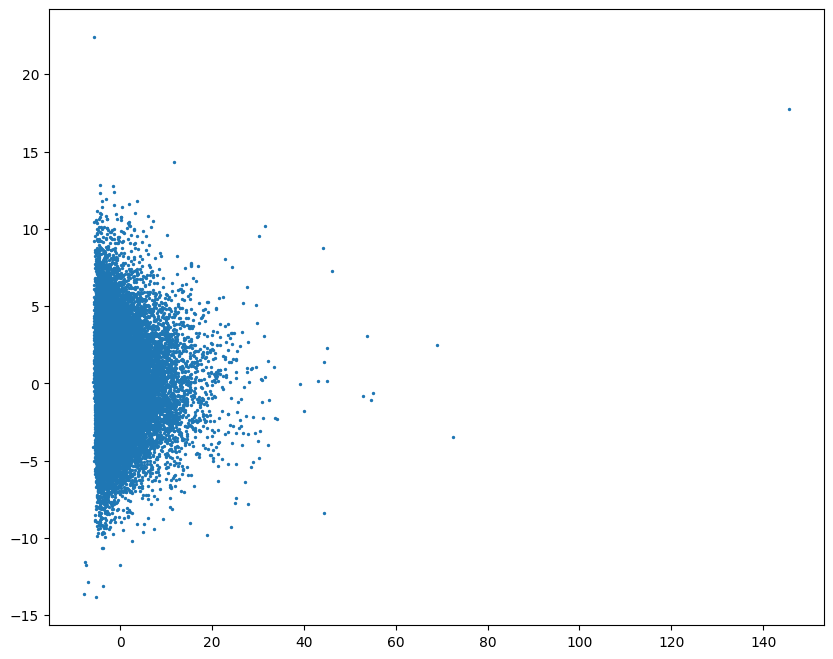

In [162]:

x0 = principal_components_f_hard[:, 0]
y0 = principal_components_f_hard[:, 1]

print(np.argmax(x0))
print(np.argmax(y0))

plt.figure(figsize=(10, 8))
plt.scatter(x0, y0, s=2)

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


=== Stats for F ===
Stats for author changes
Mean F_sim    0.595429
dtype: float64
Median F_sim    0.899861
dtype: float64
Mode    F_sim
0    1.0
Std F_sim    0.454641
dtype: float64
Min F_sim    1.617994e-17
dtype: float64
Max F_sim    1.0
dtype: float64
Quantiles          F_sim
0.25  0.002443
0.50  0.899861
0.75  0.970134
Stats for same author
Mean F_sim    0.604304
dtype: float64
Median F_sim    0.914801
dtype: float64
Mode    F_sim
0    1.0
Std F_sim    0.453652
dtype: float64
Min F_sim    1.062976e-17
dtype: float64
Max F_sim    1.0
dtype: float64
Quantiles          F_sim
0.25  0.002309
0.50  0.914801
0.75  0.971611
[9.43316974e-01 9.74801121e-01 2.11670866e-08 ... 8.45915983e-09
 9.62918378e-01 5.67851288e-17]


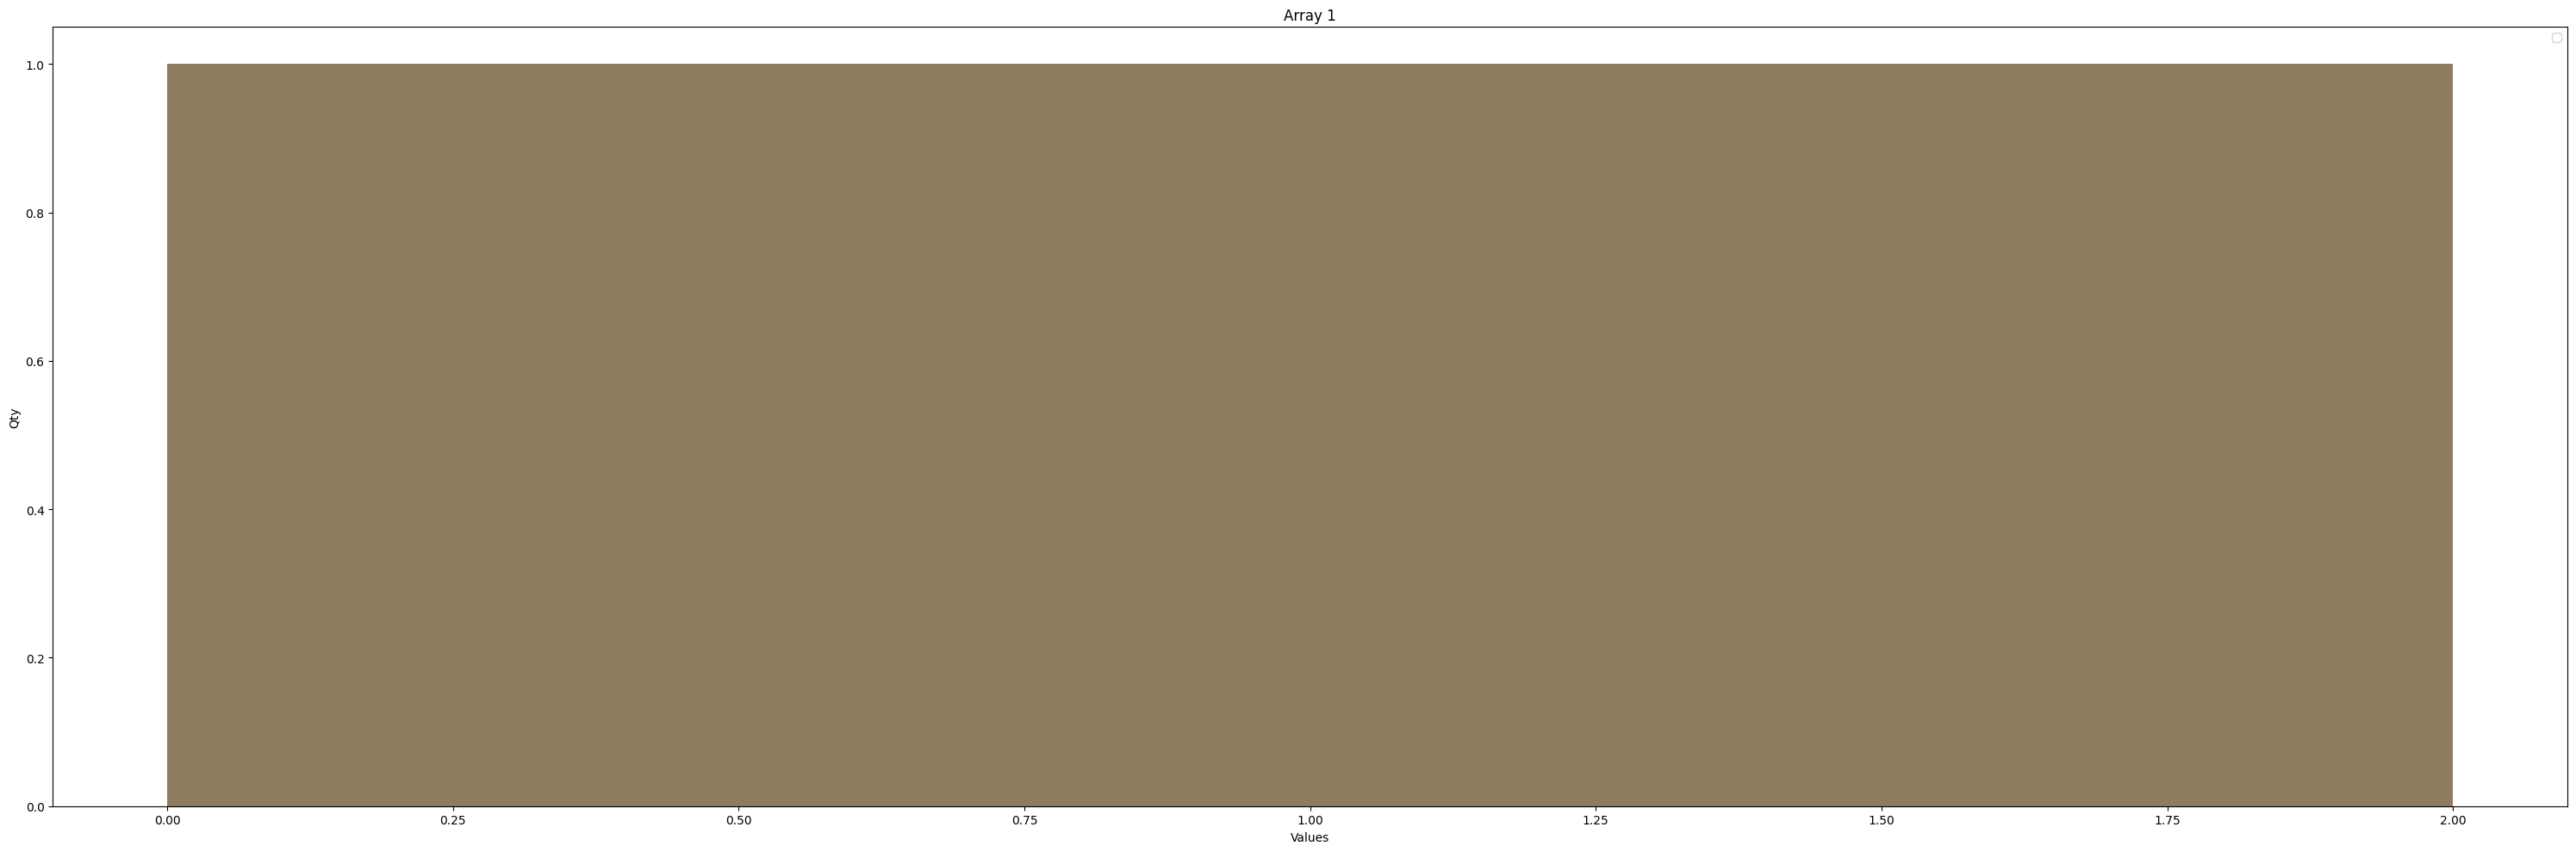

In [190]:
# Now let's extract statistics

truth_table = myparser_hard.train_truth_table
print('=== Stats for F ===')
print("Stats for author changes")
print('Mean', truth_table.loc[truth_table['Truth_changes'] == 1, ['F_sim']].mean())
print('Median', truth_table.loc[truth_table['Truth_changes'] == 1, ['F_sim']].median())
print('Mode', truth_table.loc[truth_table['Truth_changes'] == 1, ['F_sim']].mode())
print('Std', truth_table.loc[truth_table['Truth_changes'] == 1, ['F_sim']].std())
print('Min', truth_table.loc[truth_table['Truth_changes'] == 1, ['F_sim']].min())
print('Max', truth_table.loc[truth_table['Truth_changes'] == 1, ['F_sim']].max())
print('Quantiles', truth_table.loc[truth_table['Truth_changes'] == 1, ['F_sim']].quantile([0.25, 0.5, 0.75]))
print("Stats for same author")
print('Mean', truth_table.loc[truth_table['Truth_changes'] == 0, ['F_sim']].mean())
print('Median', truth_table.loc[truth_table['Truth_changes'] == 0, ['F_sim']].median())
print('Mode', truth_table.loc[truth_table['Truth_changes'] == 0, ['F_sim']].mode())
print('Std', truth_table.loc[truth_table['Truth_changes'] == 0, ['F_sim']].std())
print('Min', truth_table.loc[truth_table['Truth_changes'] == 0, ['F_sim']].min())
print('Max', truth_table.loc[truth_table['Truth_changes'] == 0, ['F_sim']].max())
print('Quantiles', truth_table.loc[truth_table['Truth_changes'] == 0, ['F_sim']].quantile([0.25, 0.5, 0.75]))

plt.figure(figsize=(30, 10))

arr1 = truth_table.loc[truth_table['Truth_changes'] == 1, ['F_sim']].values[:,0]
arr2 = truth_table.loc[truth_table['Truth_changes'] == 0, ['F_sim']].values[:,0]
print(arr1)

hist1, bins1 = np.histogram(arr1, bins=np.arange(min(arr1), max(arr1) + 1, 2), density=True)
probabilities1 = hist1 / np.sum(hist1)
plt.bar(bins1[:-1], probabilities1, width=np.diff(bins1), align='edge')

hist2, bins2 = np.histogram(arr2, bins=np.arange(min(arr2), max(arr2) + 1, 2), density=True)
probabilities2 = hist2 / np.sum(hist2)
plt.bar(bins2[:-1], probabilities2, width=np.diff(bins2), align='edge', alpha=0.5)

plt.xlabel('Values')
plt.ylabel('Qty')
plt.title('Array 1')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Displaying the plot
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


=== Stats for F ===
Stats for author changes
Mean F_sim    0.595429
dtype: float64
Median F_sim    0.899861
dtype: float64
Mode    F_sim
0    1.0
Std F_sim    0.454641
dtype: float64
Min F_sim    1.617994e-17
dtype: float64
Max F_sim    1.0
dtype: float64
Quantiles          F_sim
0.25  0.002443
0.50  0.899861
0.75  0.970134
Stats for same author
Mean F_sim    0.604304
dtype: float64
Median F_sim    0.914801
dtype: float64
Mode    F_sim
0    1.0
Std F_sim    0.453652
dtype: float64
Min F_sim    1.062976e-17
dtype: float64
Max F_sim    1.0
dtype: float64
Quantiles          F_sim
0.25  0.002309
0.50  0.914801
0.75  0.971611
[9.43316974e-01 9.74801121e-01 2.11670866e-08 ... 8.45915983e-09
 9.62918378e-01 5.67851288e-17]


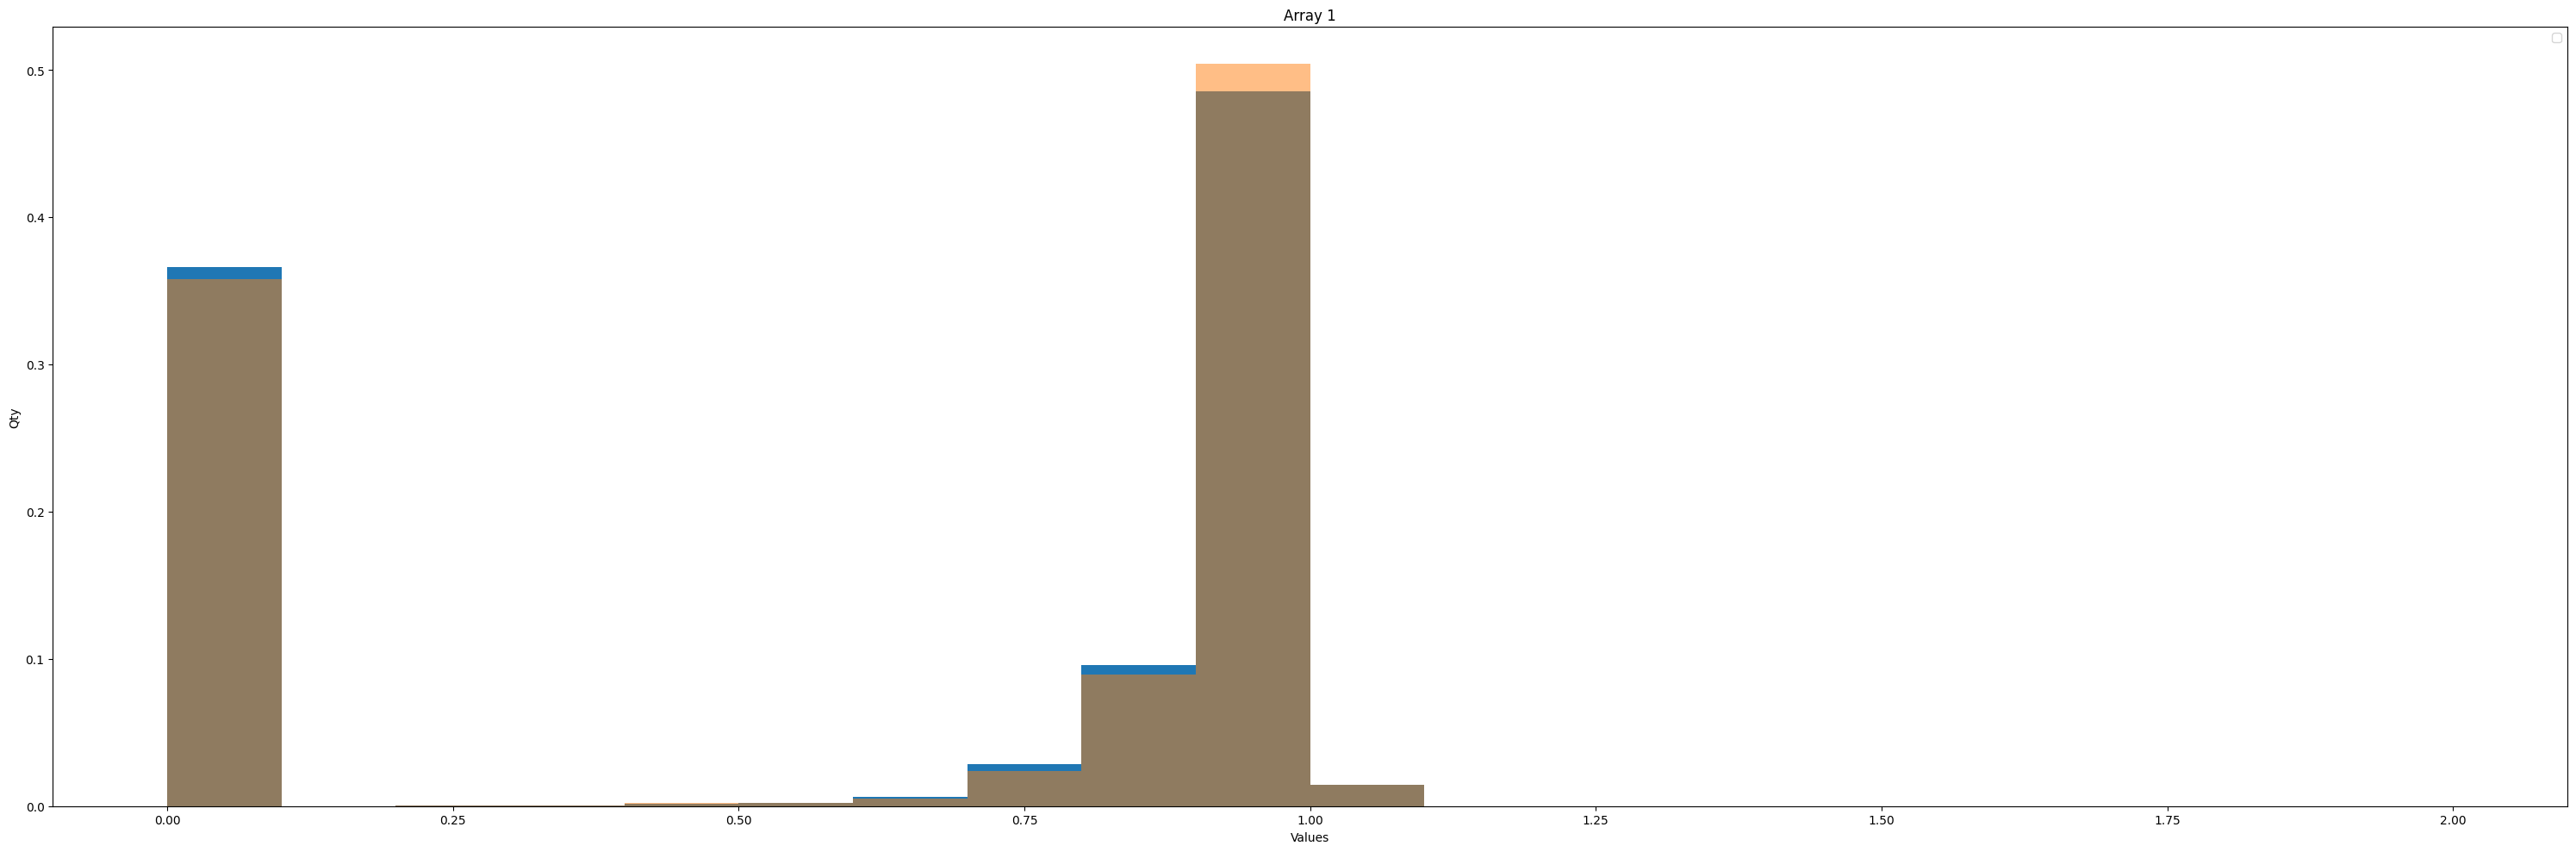

In [195]:

# Now let's extract statistics

truth_table = myparser_hard.train_truth_table
print('=== Stats for F ===')
print("Stats for author changes")
print('Mean', truth_table.loc[truth_table['Truth_changes'] == 1, ['F_sim']].mean())
print('Median', truth_table.loc[truth_table['Truth_changes'] == 1, ['F_sim']].median())
print('Mode', truth_table.loc[truth_table['Truth_changes'] == 1, ['F_sim']].mode())
print('Std', truth_table.loc[truth_table['Truth_changes'] == 1, ['F_sim']].std())
print('Min', truth_table.loc[truth_table['Truth_changes'] == 1, ['F_sim']].min())
print('Max', truth_table.loc[truth_table['Truth_changes'] == 1, ['F_sim']].max())
print('Quantiles', truth_table.loc[truth_table['Truth_changes'] == 1, ['F_sim']].quantile([0.25, 0.5, 0.75]))
print("Stats for same author")
print('Mean', truth_table.loc[truth_table['Truth_changes'] == 0, ['F_sim']].mean())
print('Median', truth_table.loc[truth_table['Truth_changes'] == 0, ['F_sim']].median())
print('Mode', truth_table.loc[truth_table['Truth_changes'] == 0, ['F_sim']].mode())
print('Std', truth_table.loc[truth_table['Truth_changes'] == 0, ['F_sim']].std())
print('Min', truth_table.loc[truth_table['Truth_changes'] == 0, ['F_sim']].min())
print('Max', truth_table.loc[truth_table['Truth_changes'] == 0, ['F_sim']].max())
print('Quantiles', truth_table.loc[truth_table['Truth_changes'] == 0, ['F_sim']].quantile([0.25, 0.5, 0.75]))

plt.figure(figsize=(30, 10))

arr1 = truth_table.loc[truth_table['Truth_changes'] == 1, ['F_sim']].values[:,0]
arr2 = truth_table.loc[truth_table['Truth_changes'] == 0, ['F_sim']].values[:,0]
print(arr1)



hist1, bins1 = np.histogram(arr1, bins=np.arange(min(arr1), max(arr1) + 1, 0.1), density=True)
probabilities1 = hist1 / np.sum(hist1)
plt.bar(bins1[:-1], probabilities1, width=np.diff(bins1), align='edge')

hist2, bins2 = np.histogram(arr2, bins=np.arange(min(arr2), max(arr2) + 1, 0.1), density=True)
probabilities2 = hist2 / np.sum(hist2)
plt.bar(bins2[:-1], probabilities2, width=np.diff(bins2), align='edge', alpha=0.5)

plt.xlabel('Values')
plt.ylabel('Qty')
plt.title('Array 1')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Displaying the plot
plt.show()


In [ ]:
# Easy

In [ ]:
# Medium

In [ ]:
# Hard